**Dataset Preparation**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Display settings for DataFrame(df)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)


# 🚀 Step **1️** - Load dataframe(df), Dataframe exploration, Clean dataframe

First 5 rows of Dataset:


,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_1,BMW i3,108.463007,Station_391,Houston,1/1/24 0:00,1/1/24 0:39,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.0,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,1/1/24 1:00,1/1/24 3:01,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,1/1/24 2:00,1/1/24 4:48,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,1/1/24 3:00,1/1/24 6:42,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.0,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,1/1/24 4:00,1/1/24 5:46,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler



Dataframe Columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   User ID                                   1320 non-null   object 
 1   Vehicle Model                             1320 non-null   object 
 2   Battery Capacity (kWh)                    1320 non-null   float64
 3   Charging Station ID                       1320 non-null   object 
 4   Charging Station Location                 1320 non-null   object 
 5   Charging Start Time                       1320 non-null   object 
 6   Charging End Time                         1320 non-null   object 
 7   Energy Consumed (kWh)                     1254 non-null   float64
 8   Charging Duration (hours)                 1320 non-null   float64
 9   Charging Rate (kW)                        1254 non-null   float64
 10  Charging Cost (U

None


Description of Numeric columns:
       Battery Capacity (kWh)  Energy Consumed (kWh)  \
count             1320.000000            1254.000000   
mean                74.534692              42.642894   
std                 20.626914              22.411705   
min                  1.532807               0.045772   
25%                 62.000000              23.881193   
50%                 75.000000              42.691405   
75%                 85.000000              61.206218   
max                193.003074             152.238758   

       Charging Duration (hours)  Charging Rate (kW)  Charging Cost (USD)  \
count                1320.000000         1254.000000          1320.000000   
mean                    2.269377           25.963003            22.551352   
std                     1.061037           14.011326            10.751494   
min                     0.095314            1.472549             0.234317   
25%                     1.397623           13.856583            13.368141   


<Figure size 1400x600 with 0 Axes>

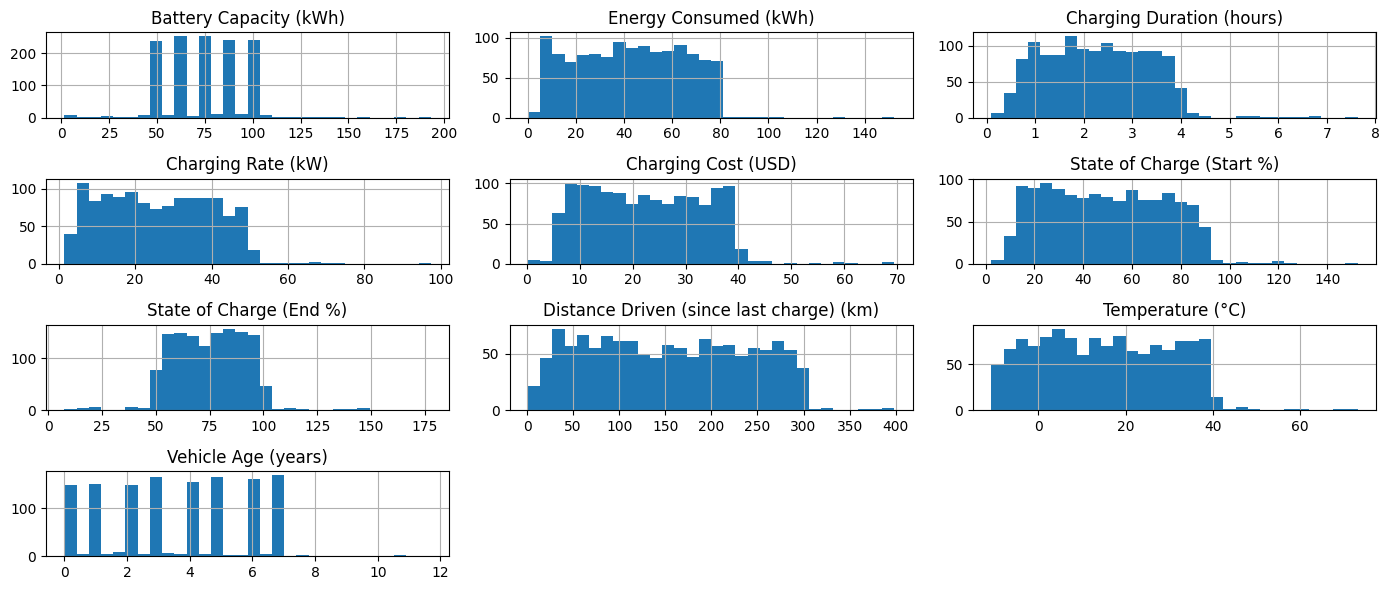

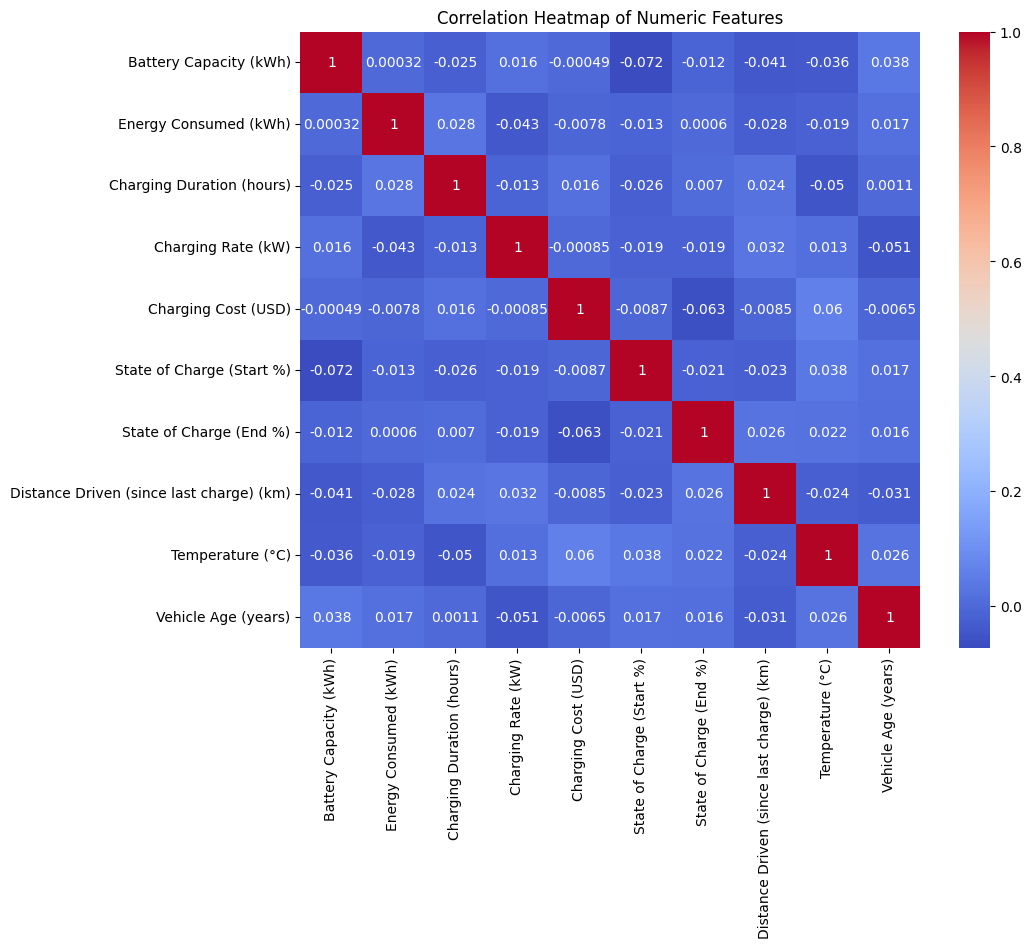

In [5]:
# 1.1 Load the CSV
file_path = '/content/ev_charging_patterns.csv' # Run Colab Just Upload
# file_path = 'content/ev_charging_patterns.csv'    # Run local
df = pd.read_csv(file_path)

# Make a copy to avoid chained assignments
df_original = df.copy()

# 1.2 Quick initial look at the dataset
print("First 5 rows of Dataset:")
display(df.head()) # default 5

# 1.3 Quick Summary of the dataset Columns
print("\nDataframe Columns:")
display(df.info())

# 1.4 Describe numeric columns, Min, 25%, 50%, 75%, Max values
print("\nDescription of Numeric columns:")
print(df.describe())

# 1.5 Look for missing values and duplicates
missing_counts = df.isna().sum()
duplicate_counts = df.duplicated().sum()
print("\nMissing values per column:")
print(missing_counts)
print("\nDuplicate values in Dataframe:")
print(f"{duplicate_counts}  Duplicate(s)\n")

# 1.6 Optional: Visual exploration
#       - Histograms or boxplots for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# You might also want to check if these columns are actually numeric dtype
# For safety, let's convert them if they are stored as strings.
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

plt.figure(figsize=(14, 6))
df[numeric_cols].hist(bins=30, figsize=(14, 6))
plt.tight_layout()
plt.show()

# 1.7 Optional: Correlation matrix for numeric columns
corr = df[numeric_cols].corr()
plt.figure(figsize=(10, 8)) # Makes the heatmap figure 10 inches by 8 inches
sns.heatmap(corr, annot=True, cmap='coolwarm')
# annot: shows correlation values inside the heatmap cells.
# cmap='coolwarm': Uses a red-to-blue colormap for visual distinction
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# 🚀 Step **2️** - Data Cleaning and Handling Missing Values

We want to predict the full driving range of an EV from a full state of charge. From prior steps, we know:
	•	Distance Driven (since last charge) (km) indicates how far the vehicle traveled since the last charge.
	•	State of Charge (Start %) (SOC_start) indicates how much battery was left upon arriving at the station.
	•	If we assume the previous charge was 100%, the fraction of battery used is (100 - \text{SOC_start})\%.
	•	Thus, the estimated full range if the battery had gone from 100% to 0% can be:
\text{Estimated Full Range}
= \text{Distance Driven} \times \frac{100}{100 - \text{SOC_start}}

In [6]:
# 2.1 Fill missing numeric values with their median
for col in numeric_cols:
    # Fill non-numeric (coerced to NaN) or empty with median
    df[col] = df[col].fillna(df[col].median())

print("\nConfirm there are no missing values in columns:")
display(df.isna().sum())


# Remove duplicate data
before_duplicates = len(df)
df.drop_duplicates(inplace=True)
after_duplicates = len(df)
print(f"Removed {before_duplicates - after_duplicates} duplicate rows.")

# Convert 'Distance Driven (since last charge) (km)' to Miles for easy usage,
# AS USA uses Miles not kilometers & # show the last 4 columns
df["Distance Driven (since last charge) (mi)"] = df["Distance Driven (since last charge) (km)"] * 0.621371
print('\nThe last 4 columns with the new Distance Driven (since last charge) (mi) feature: ')
display(df.iloc[:, -4:].head())


Confirm there are no missing values in columns:


,0
User ID,0
Vehicle Model,0
Battery Capacity (kWh),0
Charging Station ID,0
Charging Station Location,0
Charging Start Time,0
Charging End Time,0
Energy Consumed (kWh),0
Charging Duration (hours),0
Charging Rate (kW),0


Removed 0 duplicate rows.

The last 4 columns with the new Distance Driven (since last charge) (mi) feature: 


,Vehicle Age (years),Charger Type,User Type,Distance Driven (since last charge) (mi)
0,2.0,DC Fast Charger,Commuter,182.435837
1,3.0,Level 1,Casual Driver,69.663645
2,2.0,Level 2,Commuter,44.613974
3,1.0,Level 1,Long-Distance Traveler,124.011848
4,1.0,Level 1,Long-Distance Traveler,126.549565


2.2 We have 2 columns to clean; "Charging Start Time" and "Charging End Time" to just give us the time
Example:
Change: "1/1/2024 12:30:00 AM" to "12:30:00"

*** INCASE IT'S NEEDED ***

In [7]:
# 2.2 Parse Time Columns
# def extract_time_only(dt_str):
#     """
#     Takes a datetime string like '1/1/2024 12:00:00 AM'
#     Returns '12:00:00' by removing the date and AM/PM.
#     """
#     if pd.isna(dt_str) or dt_str.strip() == "":
#         return None  # We'll handle empty outside
#     parts = dt_str.strip().split()

#     # Example: parts = ['1/1/2024', '12:00:00', 'AM']
#     if len(parts) == 3:
#         # The time part is the second element e.g. '12:00:00'
#         time_part = parts[1]
#         print('\nHere')
#         print(time_part)
#         return time_part
#     else:
#         # If format is off, just return None to handle it outside
#         return None

# df["Charging Start Time"] = df["Charging Start Time"].apply(extract_time_only)
# df["Charging End Time"]   = df["Charging End Time"].apply(extract_time_only)


# df["Charging Start Time"].fillna("1:00:00", inplace=True)

# def add_hours_to_time(time_str, hours):
#     """
#     Given a time string 'HH:MM:SS' and a number of hours (float),
#     return a new time string 'HH:MM:SS' after adding 'hours'.
#     """
#     # Parse the original time
#     t = datetime.datetime.strptime(time_str, '%H:%M:%S')
#     # Add the hours
#     t_new = t + datetime.timedelta(hours=hours)
#     return t_new.strftime('%H:%M:%S')

# def fill_end_time(row):
#     """
#     If 'Charging End Time' is NaN or None,
#     create it by adding 'Charging Duration (hours)' to '1:00:00'.
#     Otherwise, keep it as is.
#     """
#     if pd.isna(row["Charging End Time"]) or row["Charging End Time"] == "":
#         duration = row["Charging Duration (hours)"]
#         new_time = add_hours_to_time("1:00:00", duration)
#         return new_time
#     else:
#         return row["Charging End Time"]

# df["Charging End Time"] = df.apply(fill_end_time, axis=1)

# df["Charging Start Time"].fillna("1:00:00", inplace=True)

# display(df.head())

2.2 Remove Out-of-Range Value: 118 kWh is the highest battery capacity of a production EV has.

Any record above that value should be dropped.


In [8]:
# 2.2 Remove Out-of-Range Values
initial_shape = df.shape[0]  # Number of rows before condition filtering

condition = (
    (df["Battery Capacity (kWh)"] <= 118)
)
# Keep only rows meeting the above condition
df = df[condition]

removed_rows = initial_shape - df.shape[0]
print(f"\nRemoved {removed_rows} unrealistic rows.")



Removed 17 unrealistic rows.


# 🚀 Step **3** Feature Engineering

3.1 Create Three(3) New Features

In [9]:
# 3.1 Create features Vehicle Efficiency(km per kWh) and Driving Range (km)
df["Vehicle Efficiency(mi per kWh)"] = (
    df["Distance Driven (since last charge) (mi)"] / df["Energy Consumed (kWh)"]
)

df["Driving Range (mi)"] = (
    df["Vehicle Efficiency(mi per kWh)"] * df["Battery Capacity (kWh)"]
)
"""
Vehicle Efficiency(mi per kWh) & Driving Range (mi) uses:
    1) Will be used to estimate useful battery efficiency, while
       vehicle age and maximum driving range of the vehicle into account
       in order to schedule recharging during short or long road trips.
"""

# 3.2 Create feature Effective Energy Gained after Charge(kWh)
df["Effective Energy Gained after Charge(kWh)"] = (
    df["Battery Capacity (kWh)"] * (
        (df["State of Charge (End %)"] - df["State of Charge (Start %)"]) / 100.0
    )
)
"""
Effective Energy Gained after Charge(kWh) uses:
    1) Will be used with 'Charging Duration (hours)', against "Battery Capacity (kWh)"
       to estimate Charging Duration per charger type.

    2) If Effective Energy Gained after Charge(kWh) is negative,
       Means energy drops after charge: XXX Indicating Battery is Bad XXX = Bad data.
       So take row out of dataset.
"""

# 3.3 Confirm New Features have been added, Check last 5 columns
display(df.iloc[:, -5:].head())

,User Type,Distance Driven (since last charge) (mi),Vehicle Efficiency(mi per kWh),Driving Range (mi),Effective Energy Gained after Charge(kWh)
0,Commuter,182.435837,3.004922,325.922830,61.551007
1,Casual Driver,69.663645,5.645684,564.568370,74.548566
2,Commuter,44.613974,2.332284,174.921311,47.297258
3,Long-Distance Traveler,124.011848,1.560725,78.036272,8.252162
4,Long-Distance Traveler,126.549565,6.447037,322.351861,4.742418


3.4:
    1. 564 mi is the longest range a production EV can drive.
    2. If "Effective Energy Gained after Charge(kWh)" is negative, it means
       the battery is faulty.


In [10]:
# 3.4 Remove out of range values
unfiltered_range_shape = df.shape[0]  # Number of rows before condition filtering

# records above 564 Miles is the longest range a production EV can drive
new_condition = (
    (df["Driving Range (mi)"] <= 564) &
    (df["Effective Energy Gained after Charge(kWh)"] >= 0)
)
# Keep only rows meeting the above condition
df = df[new_condition]

filtered_rows = unfiltered_range_shape - df.shape[0]
print(f"\nRemoved {filtered_rows} unrealistic or faulty EV battery rows.")

# Define our essential columns
critical_cols = [
    "Battery Capacity (kWh)",
    "Charging Start Time",
    "Charging End Time",
    "Energy Consumed (kWh)",
    "Charging Duration (hours)",
    "Charging Rate (kW)",
    "State of Charge (Start %)",
    "State of Charge (End %)",
    "Distance Driven (since last charge) (mi)",
    "Temperature (°C)",
    "Vehicle Age (years)",
    "Charger Type",
    "Vehicle Efficiency(mi per kWh)",
    "Driving Range (mi)",
    "Effective Energy Gained after Charge(kWh)"
]

# Check if any critical columns are empty or NaN
empty_crit = df[critical_cols].isna().sum()
print("\nNumber of empty (NaN) values in each critical column:")
print(empty_crit)

# If you want to print the rows themselves:
# rows_with_empty = df[df[critical_cols].isna().any(axis=1)]
# display(rows_with_empty)



Removed 380 unrealistic or faulty EV battery rows.

Number of empty (NaN) values in each critical column:
Battery Capacity (kWh)                       0
Charging Start Time                          0
Charging End Time                            0
Energy Consumed (kWh)                        0
Charging Duration (hours)                    0
Charging Rate (kW)                           0
State of Charge (Start %)                    0
State of Charge (End %)                      0
Distance Driven (since last charge) (mi)     0
Temperature (°C)                             0
Vehicle Age (years)                          0
Charger Type                                 0
Vehicle Efficiency(mi per kWh)               0
Driving Range (mi)                           0
Effective Energy Gained after Charge(kWh)    0
dtype: int64


# 🚀 Step **4**: One-Hot Encoding “Charger Type”

One hot encode the column "Charger Type” so: “Level 1” = “1”, “Level 2” = “2”, “DC Fast Charger” = “3”

In [11]:
# Label encoding map
charger_map = {
    "Level 1": 1,
    1: 1,
    "Level 2": 2,
    2: 2,
    "DC Fast Charger": 3,
    3: 3
}

# Apply the map to “Charger Type.”
df["Charger Type"] = df["Charger Type"].map(charger_map)


# Count how many unmatched (NaN) entries remain after mapping
unmatched_count = df["Charger Type"].isna().sum()
print(f"Number of unmatched 'Charger Type' rows: {unmatched_count}")

# 4.2 Set all unmatched "Charger Type" to (Level 1) “1”
df["Charger Type"] = df["Charger Type"].fillna(1)



Number of unmatched 'Charger Type' rows: 0


# 🚀 Step **5**:  Split your data into Train (70%), Validation (15%), and Test (15%)

In [12]:
# Step 5

# 5.1) Shuffle the data
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 5.2) Calculate total length
total_length = len(df_shuffled)

# 5.3) Calculate the cut points
# Note: Depending on rounding, you might end up with a small difference (odd rows)
# (e.g., 1 row more or less in the final slice) because we use int().
train_end = int(0.7 * total_length)  # This is 70%
test_end  = train_end + int(0.15 * total_length)  # This adds 15% on top of 70%

# 5.4) Slice the DataFrame
train_df = df_shuffled.iloc[:train_end].copy() # 0-70%
val_df   = df_shuffled.iloc[test_end:].copy()  # 70-85%
test_df  = df_shuffled.iloc[train_end:test_end].copy() #85-100%

# 5) Output
train_df.to_csv("training.csv", index=False)
val_df.to_csv("validation.csv", index=False)
test_df.to_csv("test.csv", index=False)

print("Number of rows in each dataset:")
print(f"  Training:   {len(train_df)}")
print(f"  Validation: {len(val_df)}")
print(f"  Test:       {len(test_df)}")



Number of rows in each dataset:
  Training:   646
  Validation: 139
  Test:       138


# 🚀 Step **6**: Train Model

Beginning of training the models



### a. Decision Tree Regressor

In [13]:
from sklearn.tree import DecisionTreeRegressor

# Features and target
features = df.select_dtypes(include=[np.number]).drop(columns=['Driving Range (mi)'])
target = df['Driving Range (mi)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate
predictions = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"Decision Tree Regressor Results:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

Decision Tree Regressor Results:
RMSE: 21.01
R² Score: 0.969


On average, the predicted driving range from the Decision Tree Regressor is 21.01 miles off from the actual value.

The model explains 96.9% of the variation in driving range across vehicles.




### b. Random Forest Regressor

In [14]:
features = df.select_dtypes(include=[np.number]).drop(columns=['Driving Range (mi)'])
target = df['Driving Range (mi)']

from sklearn.ensemble import RandomForestRegressor

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize (not strictly necessary for Random Forest, but used here to match previous setup)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate
rf_predictions = rf_model.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_predictions)

print("Random Forest Regressor Results:")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R² Score: {rf_r2:.3f}")



Random Forest Regressor Results:
RMSE: 16.67
R² Score: 0.981


On average, the model's predictions are off by about 16.67 miles from the true driving range. This is an improvement over the Decision Tree Regressor (RMSE of 21.01), indicating the Random Forest is making more accurate predictions.

A score of 0.981 means that the Random Forest model explains 98.1% of the variability in the driving range.

### c. Gradient Boosting Regressor (XGBoost)

In [15]:
import xgboost as xgb

# Features and target
features = df.select_dtypes(include=[np.number]).drop(columns=['Driving Range (mi)'])
target = df['Driving Range (mi)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize (Gradient Boosting can handle non-standardized data, but scaling might help)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Gradient Boosting Regressor (XGBoost)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Evaluate
xgb_predictions = xgb_model.predict(X_test_scaled)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

print("XGBoost Regressor Results:")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"R² Score: {xgb_r2:.3f}")

XGBoost Regressor Results:
RMSE: 13.63
R² Score: 0.987


On average, The model are off by about 13.63 miles from the true values.

This is better than the Random Forest Regressor (RMSE of 16.67) and Decision Tree Regressor (RMSE of 21.01), indicating that XGBoost is providing more accurate predictions.

The model also explains 98.7% of the variance in the driving range.

Overall, this suggests that **XGBoost** is a stronger model for predicting driving range, especially since it handles complex patterns and relationships in the data through gradient boosting.

#🚀 Step **7**: Validate and Compare

In [16]:
from sklearn.model_selection import train_test_split

# First split into 70% training and 30% temporary (validation + test sets)
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=42)

# Then split the 30% temporary set into 50% validation and 50% test (15% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training Set: {X_train.shape[0]} samples")
print(f"Validation Set: {X_val.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")


Training Set: 646 samples
Validation Set: 138 samples
Test Set: 139 samples


In [17]:
# Train models on 70% training data
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the validation set (15% validation data)
dt_predictions = dt_model.predict(X_val)
rf_predictions = rf_model.predict(X_val)
xgb_predictions = xgb_model.predict(X_val)

# Calculate evaluation metrics (MAE, MSE, RMSE, R²) for each model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Function to calculate all metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Calculate metrics for each model
dt_mae, dt_mse, dt_rmse, dt_r2 = calculate_metrics(y_val, dt_predictions)
rf_mae, rf_mse, rf_rmse, rf_r2 = calculate_metrics(y_val, rf_predictions)
xgb_mae, xgb_mse, xgb_rmse, xgb_r2 = calculate_metrics(y_val, xgb_predictions)

# Print the results for comparison
print("Decision Tree Regressor Results:")
print(f"MAE: {dt_mae:.2f}, MSE: {dt_mse:.2f}, RMSE: {dt_rmse:.2f}, R² Score: {dt_r2:.3f}")

print("\nRandom Forest Regressor Results:")
print(f"MAE: {rf_mae:.2f}, MSE: {rf_mse:.2f}, RMSE: {rf_rmse:.2f}, R² Score: {rf_r2:.3f}")

print("\nXGBoost Regressor Results:")
print(f"MAE: {xgb_mae:.2f}, MSE: {xgb_mse:.2f}, RMSE: {xgb_rmse:.2f}, R² Score: {xgb_r2:.3f}")


Decision Tree Regressor Results:
MAE: 12.13, MSE: 576.29, RMSE: 24.01, R² Score: 0.962

Random Forest Regressor Results:
MAE: 11.00, MSE: 676.06, RMSE: 26.00, R² Score: 0.955

XGBoost Regressor Results:
MAE: 8.56, MSE: 326.56, RMSE: 18.07, R² Score: 0.978


### **Conclusion:**
`XGBoost Regressor` is the best performing model overall based on the MAE, MSE, RMSE, and R² Score. It provides the most accurate predictions and the best fit to the data.

Random Forest is also a strong contender with competitive performance, but still trails XGBoost by a small margin.

Decision Tree performs well but is slightly less accurate and has higher error metrics compared to the other two models.

If the goal is to maximize prediction accuracy and minimize errors, XGBoost would be the model of choice.

#🚀 Step **8**: Ensemble Model

### a. Creating Voting Regressor

In [18]:
from sklearn.ensemble import VotingRegressor

# Define the base models
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the models on the training data
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Create the Voting Regressor
voting_regressor = VotingRegressor(estimators=[('dt', dt_model), ('rf', rf_model), ('xgb', xgb_model)])

# Train the Voting Regressor
voting_regressor.fit(X_train, y_train)

# Predict on the validation set
voting_predictions = voting_regressor.predict(X_val)

# Evaluate the Voting Regressor
voting_mae, voting_mse, voting_rmse, voting_r2 = calculate_metrics(y_val, voting_predictions)

# Print the results for the Voting Regressor
print("\nVoting Regressor Results:")
print(f"MAE: {voting_mae:.2f}, MSE: {voting_mse:.2f}, RMSE: {voting_rmse:.2f}, R² Score: {voting_r2:.3f}")



Voting Regressor Results:
MAE: 9.26, MSE: 437.37, RMSE: 20.91, R² Score: 0.971


### b1. Evaluate on the Test set

In [ ]:
# Predict on the test set
voting_test_predictions = voting_regressor.predict(X_test)

# Calculate evaluation metrics for the test set
voting_test_mae, voting_test_mse, voting_test_rmse, voting_test_r2 = calculate_metrics(y_test, voting_test_predictions)

# Print the results for the Voting Regressor on the test set
print("\nVoting Regressor Test Results:")
print(f"MAE: {voting_test_mae:.2f}, MSE: {voting_test_mse:.2f}, RMSE: {voting_test_rmse:.2f}, R² Score: {voting_test_r2:.3f}")



Voting Regressor Test Results:
MAE: 5.17, MSE: 80.35, RMSE: 8.96, R² Score: 0.994


### b2. Evaluate on the Validation set

In [ ]:
# Predict on the validation set using the Voting Regressor
voting_val_predictions = voting_regressor.predict(X_val)

# Evaluate the Voting Regressor on the validation set
voting_val_mae, voting_val_mse, voting_val_rmse, voting_val_r2 = calculate_metrics(y_val, voting_val_predictions)

# Print the results for the Voting Regressor on the validation set
print("\nVoting Regressor Validation Results:")
print(f"MAE: {voting_val_mae:.2f}, MSE: {voting_val_mse:.2f}, RMSE: {voting_val_rmse:.2f}, R² Score: {voting_val_r2:.3f}")



Voting Regressor Validation Results:
MAE: 9.26, MSE: 437.37, RMSE: 20.91, R² Score: 0.971


### c. Bayesian Ensemble Model of 3 models above

In [ ]:
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

from sklearn.model_selection import train_test_split

# First split into train and temp (70% train, 30% temp)
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=42)

# Then split temp into validation and test (15% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Now scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train the model
bayesian_model = BayesianRidge()
bayesian_model.fit(X_train_scaled, y_train)

# Predict on validation and test sets
val_preds_bayes = bayesian_model.predict(X_val_scaled)
test_preds_bayes = bayesian_model.predict(X_test_scaled)

# Evaluate on Validation set
val_mae = mean_absolute_error(y_val, val_preds_bayes)
val_mse = mean_squared_error(y_val, val_preds_bayes)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, val_preds_bayes)

print("Bayesian Regressor - Validation Set:")
print(f"MAE: {val_mae:.2f}, MSE: {val_mse:.2f}, RMSE: {val_rmse:.2f}, R² Score: {val_r2:.3f}")

# Evaluate on Test set
test_mae = mean_absolute_error(y_test, test_preds_bayes)
test_mse = mean_squared_error(y_test, test_preds_bayes)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_preds_bayes)

print("\nBayesian Regressor - Test Set:")
print(f"MAE: {test_mae:.2f}, MSE: {test_mse:.2f}, RMSE: {test_rmse:.2f}, R² Score: {test_r2:.3f}")


Bayesian Regressor - Validation Set:
MAE: 21.32, MSE: 1035.59, RMSE: 32.18, R² Score: 0.931

Bayesian Regressor - Test Set:
MAE: 17.56, MSE: 622.05, RMSE: 24.94, R² Score: 0.953


✅ RESULT SUMMARY

L: Lower

H: Higher

| Model                   | MAE_Val | MSE_Val | RMSE_Val | R2_Val | MAE_Test | MSE_Test | RMSE_Test | R2_Test |
|------------------------|---------|---------|----------|--------|-----------|-----------|------------|----------|
| Voting Regressor        | 9.26-L    | 437.37-L    | 20.91-L    | 0.971-H  | 5.17-L      | 80.35-L       | 8.96 -L      | 0.994-H    |
| Bayesian Ridge Regressor| 21.32   | 1035.59 | 32.18    | 0.931  | 17.56     | 622.05     | 24.94       | 0.953    |




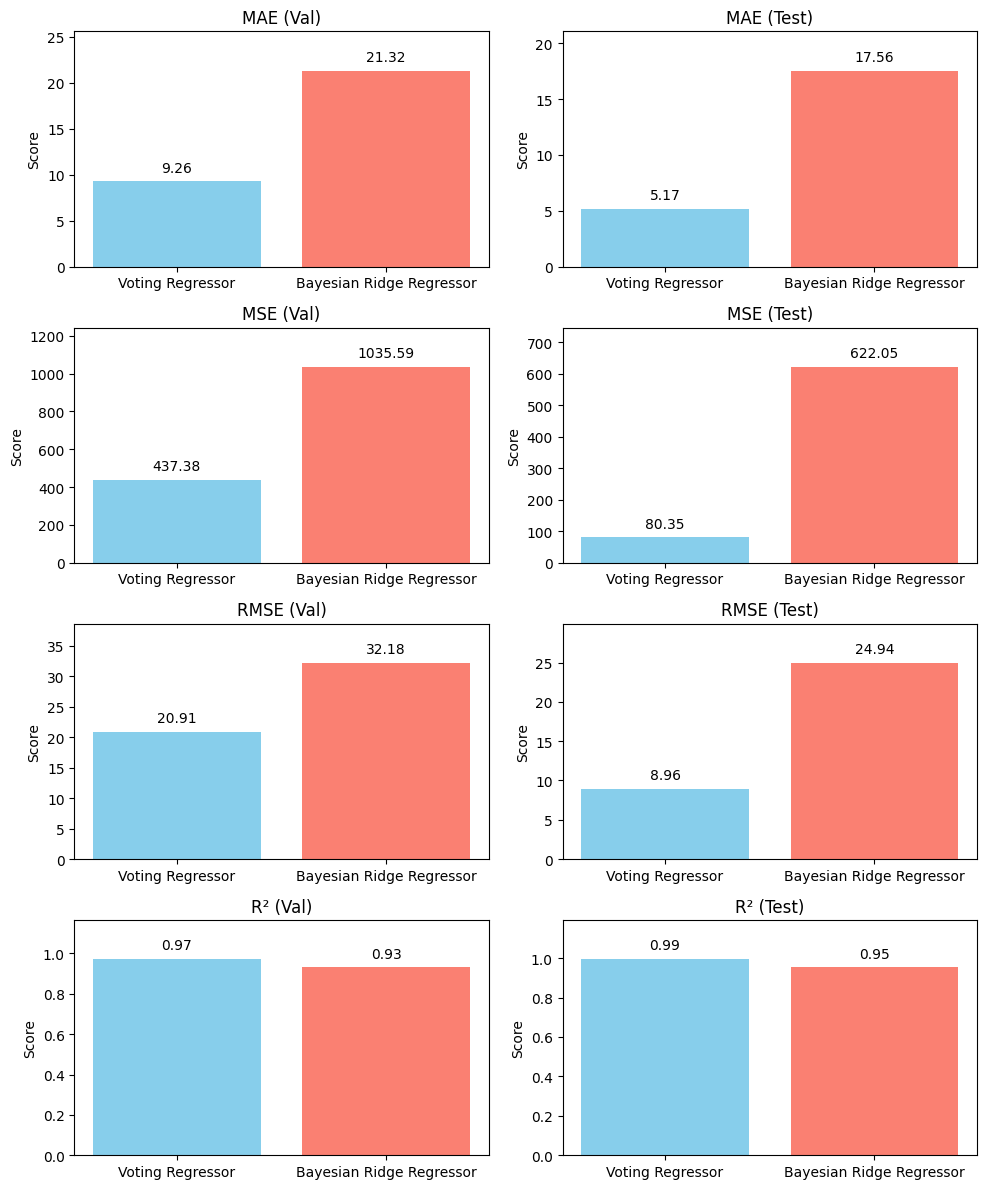

In [22]:
import matplotlib.pyplot as plt

# Data
models = ['Voting Regressor', 'Bayesian Ridge Regressor']
mae_val = [9.26, 21.32]
mse_val = [437.377, 1035.59]
rmse_val = [20.91, 32.18]
r2_val = [0.971, 0.931]
mae_test = [5.17, 17.56]
mse_test = [80.35, 622.05]
rmse_test = [8.96, 24.94]
r2_test = [0.994, 0.953]

# Create the bar plots with smaller figure and more spacing
fig, axs = plt.subplots(4, 2, figsize=(10, 12))

# Titles and data
titles = ['MAE (Val)', 'MAE (Test)', 'MSE (Val)', 'MSE (Test)',
          'RMSE (Val)', 'RMSE (Test)', 'R² (Val)', 'R² (Test)']
data = [mae_val, mae_test, mse_val, mse_test,
        rmse_val, rmse_test, r2_val, r2_test]

# Plotting loop
for i, ax in enumerate(axs.flat):
    ax.bar(models, data[i], color=['skyblue', 'salmon'])
    ax.set_title(titles[i])
    ax.set_ylabel('Score')
    ax.set_ylim([0, max(data[i]) * 1.2])  # dynamic y-axis limit for better visuals
    for idx, val in enumerate(data[i]):
        ax.text(idx, val + max(data[i]) * 0.05, f'{val:.2f}', ha='center')

# Layout adjustment
plt.tight_layout()
plt.show()


Voting Regressor outperformed Bayesian model on both validation and test sets in all metrics (MAE, RMSE, R²).

The Voting Regressor combines the strengths of the top three models (XGBoost, Random Forest, Decision Tree), resulting in a more robust and accurate prediction.

Bayesian Regressor is still a solid performer, but more sensitive to linear assumptions and less flexible than the ensemble.

